In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from aligners.helpers import load_reference_genome
import random

In [6]:
fasta_file = "/mnt/SSD2/pholur/General_Models/data/thermus_aquaticus/thermus_aquaticus.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)

In [7]:
dictionary_of_reference.keys()

dict_keys(['NZ_CP010822.1', 'NZ_CP010823.1', 'NZ_CP010824.1', 'NZ_CP010825.1', 'NZ_CP010826.1'])

In [8]:
for k,v in dictionary_of_reference.items():
    print(k, len(v))

NZ_CP010822.1 2158963
NZ_CP010823.1 14448
NZ_CP010824.1 16597
NZ_CP010825.1 69906
NZ_CP010826.1 78727


In [21]:
subsequence_of_reference = dictionary_of_reference["NZ_CP010822.1"]

In [10]:
print(subsequence_of_reference[:500 ])

GTGGCCTTGACGCACGAGGCGGTCTGGCAGCACGTTCTGGAGCACATCCGCCGCAACATCACCGAGGTGGAGTACCACACCTGGTTTGAAAGGATCCGCCCCCTGGGTATCCGGGAAGGGGTTTTGGAGCTGGCGGTGCCCACCTCCTTCGCCCTGGACTGGATCAAGCGGCACTACGCCCCCCTGATCCAGGAGGCTTTAGGCCTCCTGGGGGCCCAGGTACCCCGCTTTGAGCTTTTGGTGGTGCCCGGAGCCGCCCAGCCGGTCCAGGTGGACATCTTCCAGGCCGTCCCCCAGGCCGACCAGGGGAAGTCCAAGCTCAACCCCAAGTACACCTTTGAGAACTTCGTGGTGGGGCCCAACAACAACCTGGCCCACGCCGCGGCCGTGGCCGTGGCCGAGTCGCCCGGCAAGGCCTACAACCCCCTTTTCATCTACGGGGGGGTGGGCCTGGGCAAGACCCACCTCATGCACGCCGTGGGCCACTCGGTAGCCAAGCG


In [11]:
def swap_characters(input_string):
    # Calculate the number of characters to swap (10% of the string length)
    num_chars_to_swap = int(len(input_string) * 0.01)
    
    # Convert string to a list to allow character swapping
    chars = list(input_string)
    
    # Perform swaps
    for _ in range(num_chars_to_swap):
        # Randomly select two distinct indices within the string length
        index1, index2 = random.sample(range(len(chars)), 2)
        
        # Swap the characters at the selected indices
        chars[index1], chars[index2] = chars[index2], chars[index1]
    
    # Convert the list back to a string
    modified_string = ''.join(chars)
    return modified_string

In [32]:
def get_subsequences(sequence, sample_length, overlap, mode="raw"):
    start = 0
    sample_count = 0
    subsequences = []
    if mode == "raw":
        while start < len(sequence): # NASA-esque hard upper limit
            subsequences.append([
                sequence[start:min(start + sample_length, len(sequence))].upper(), 
                str(sample_count)
                ]
            )
            start += sample_length
            if overlap != None and overlap < sample_length:
                start -= overlap
            sample_count += 1
            
    elif mode == "simulated":
        while start < len(sequence): # NASA-esque hard upper limit
            # Calculate the random sample length with mean at sample_length and range of sample_length ± 200
            random_sample_length = min(max(int(random.uniform(sample_length - 200, sample_length + 200)), 1), len(sequence) - start)
            subsequences.append([
                sequence[start:min(start + random_sample_length, len(sequence))].upper(),
                str(sample_count)
            ])
            
            if (start + random_sample_length) >= len(sequence):
                break
            
            overlap_fine = int(random.uniform(overlap - 100, overlap + 100))
            start += random_sample_length - overlap_fine
            sample_count += 1
            
    elif mode == "simulated_with_noise":
        while start < len(sequence): # NASA-esque hard upper limit
            # Calculate the random sample length with mean at sample_length and range of sample_length ± 200
            random_sample_length = min(max(int(random.uniform(sample_length - 200, sample_length + 200)), 1), len(sequence) - start)
            parter = sequence[start:min(start + random_sample_length, len(sequence))].upper()
            
            subsequences.append([
                swap_characters(parter),
                str(sample_count)
            ])
            
            if (start + random_sample_length) >= len(sequence):
                break
            
            start += random_sample_length - int(random.uniform(overlap - 100, overlap + 100))
            sample_count += 1
            
    return subsequences

In [60]:
splices = get_subsequences(subsequence_of_reference, 1000, 800, mode="simulated") # vs. simulated

In [61]:
from inference_models import EvalModel
import torch
import yaml

with open("configs/model_checkpoints.yaml", 'r') as stream:
    checkpoints = yaml.safe_load(stream)

from dna2vec.model import model_from_config

def _load_model_for_inference(alias, device="cuda:3"):
    received = torch.load(checkpoints[alias], map_location="cpu")
    config = received["config"]
    config.model_config.tokenizer_path = checkpoints["tokenizer"]
    encoder, pooling, tokenizer = model_from_config(config.model_config)
    encoder.load_state_dict(received["model"])
    encoder.eval()
    model_params = {
                                "tokenizer": tokenizer,
                                "model": encoder,
                                "pooling": pooling,
                    }
    eval_model = EvalModel(
                model_params["tokenizer"],
                model_params["model"],
                model_params["pooling"],
                device = device
    )
    return eval_model

In [62]:
print(len(splices))

10856


In [63]:
from tqdm import tqdm
eval_model = _load_model_for_inference("trained-all-longer")

In [64]:
representations = []
labels = []
for splice in tqdm(splices):
    representations.append(eval_model.encode([splice[0]]))
    labels.append(splice[1])

  0%|          | 0/10856 [00:00<?, ?it/s]/mnt/SSD2/pholur/environments/dna2vec/lib/python3.11/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
  0%|          | 25/10856 [00:00<00:43, 248.33it/s]

100%|██████████| 10856/10856 [00:48<00:00, 221.66it/s]


In [65]:
import numpy as np
representations_np = np.array(representations)

In [66]:
representations_np.shape

(10856, 384)

In [67]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[100:200],
     representations_np[200:300]))

In [68]:
import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

In [69]:
vectors.shape

(300, 2)

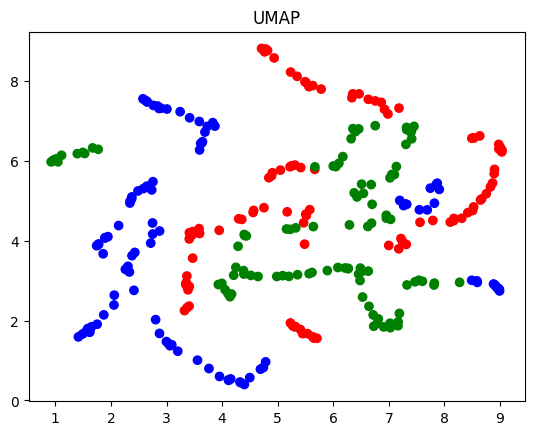

In [70]:
import matplotlib.pyplot as plt
plt.scatter(vectors[:,0], vectors[:,1], color=["red"]*100 + ["green"]*100 + ["blue"]*100)#, labels=labels)
plt.title('UMAP');

In [71]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[10000:10100],
     representations_np[5000:5100]))

In [72]:
import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

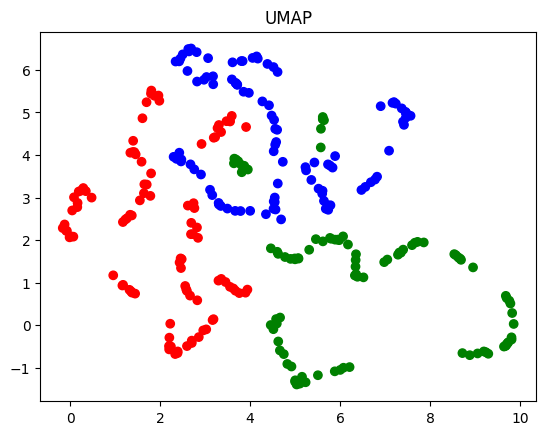

In [73]:
import matplotlib.pyplot as plt
plt.scatter(vectors[:,0], vectors[:,1], color=["red"]*100 + ["green"]*100 + ["blue"]*100)#, labels=labels)
plt.title('UMAP');

## Original space kNN graph processing

In [74]:
neighbor_graph = model.graph_

In [75]:
neighbor_graph

<300x300 sparse matrix of type '<class 'numpy.float32'>'
	with 3394 stored elements in Compressed Sparse Row format>

In [76]:
neighbor_graph = neighbor_graph.todense()

In [77]:
neighbor_graph

matrix([[0.        , 1.        , 0.8765124 , ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.        , 1.        , ..., 0.        , 0.        ,
         0.48163575],
        [0.8765124 , 1.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.9529253 ,
         0.6785036 ],
        [0.        , 0.        , 0.        , ..., 0.9529253 , 0.        ,
         1.        ],
        [0.        , 0.48163575, 0.        , ..., 0.6785036 , 1.        ,
         0.        ]], dtype=float32)

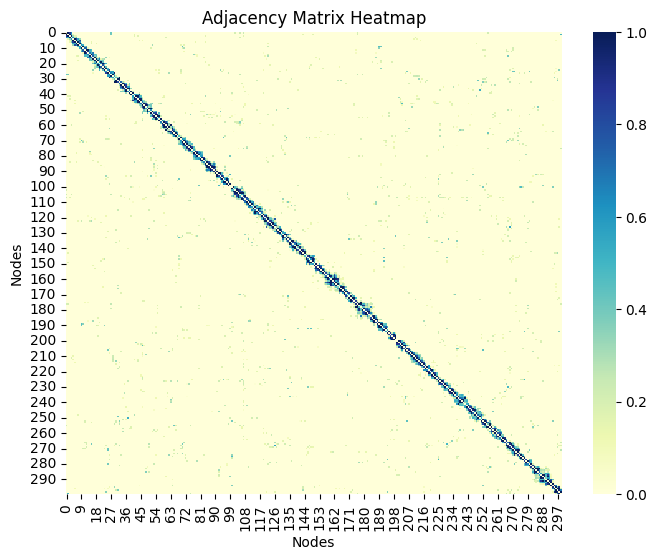

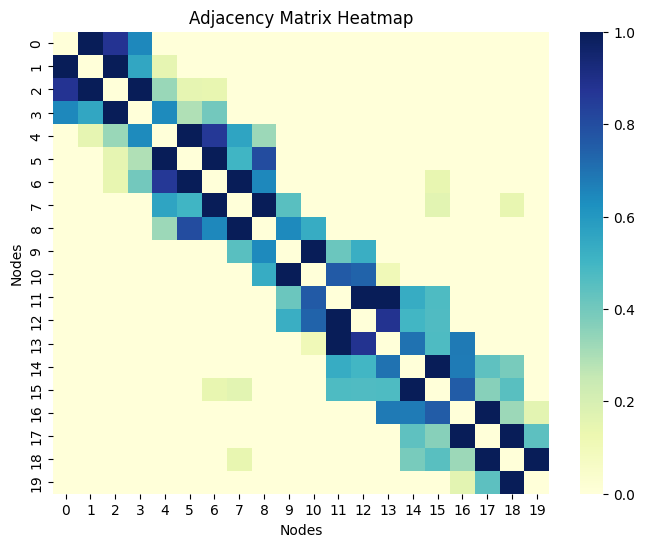

In [78]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph, cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph[:20,:20], cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

## Transform it into a TSP for NetworkX support
TSP has approximate and more-optimized kernels than finding the hamilton path, that instead appears to time-out under some specific constraints.

In [79]:
import networkx as nx
neighbor_graph[-1,0] = 1 # ensure easy return

In [80]:
G = nx.Graph((1 - neighbor_graph) + 0.1)

Text(0, 0.5, 'Fragment')

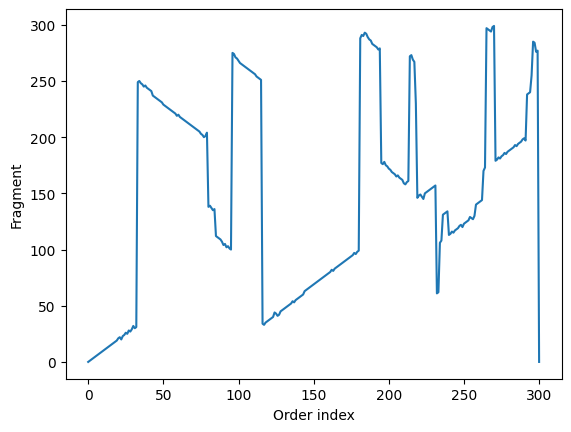

In [81]:
hamiltonian_path = nx.approximation.greedy_tsp(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

Text(0, 0.5, 'Fragment')

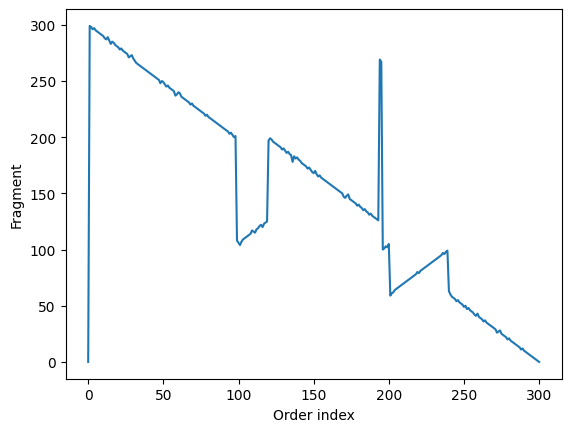

In [82]:
hamiltonian_path = nx.approximation.christofides(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")

In [83]:
cutset = np.vstack(
    (representations_np[:100],
     representations_np[100:200],
     representations_np[200:300]))

import umap
model = umap.UMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(cutset)

In [84]:
neighbor_graph = model.graph_.todense()

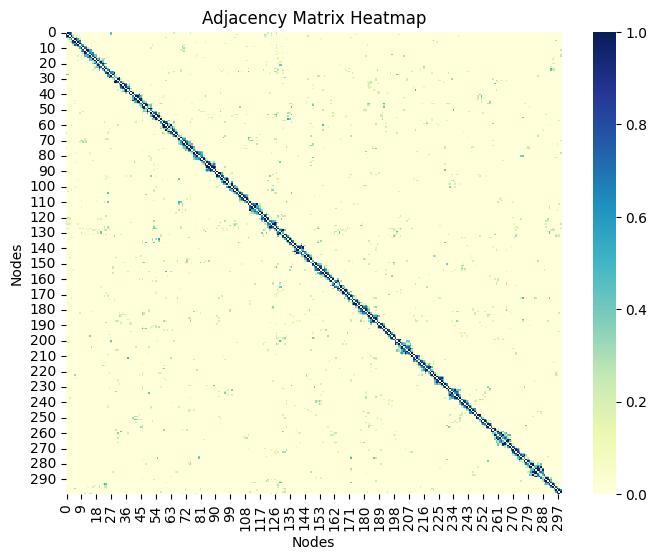

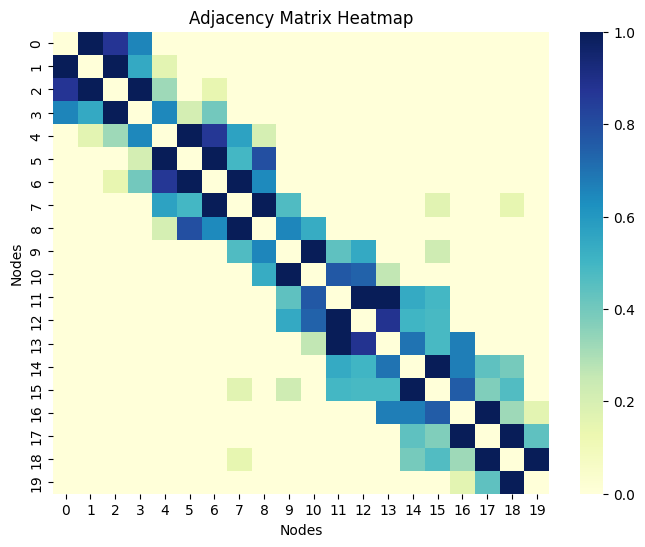

In [85]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph, cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(neighbor_graph[:20,:20], cmap='YlGnBu', fmt='d')
plt.title('Adjacency Matrix Heatmap')
plt.xlabel('Nodes')
plt.ylabel('Nodes')
plt.show()

Text(0, 0.5, 'Fragment')

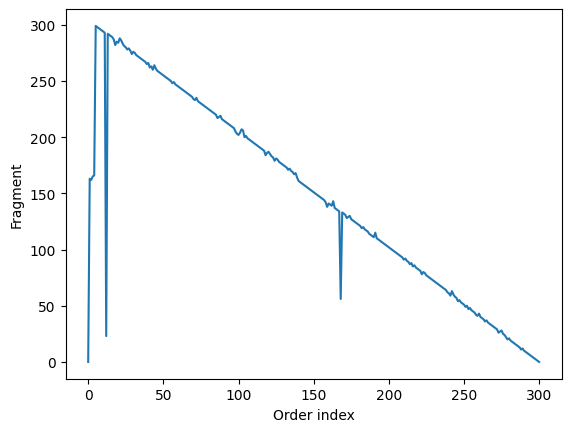

In [86]:
import networkx as nx
# neighbor_graph[-1,0] = 1 # ensure easy return
G = nx.Graph((1 - neighbor_graph) + 0.1)
hamiltonian_path = nx.approximation.christofides(G)
plt.plot(range(len(hamiltonian_path)), hamiltonian_path)
plt.xlabel("Order index")
plt.ylabel("Fragment")